In [1]:
#import osmnx as ox
import numpy as np
import pandas as pd
import os
#import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import ast

#buffer join
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import transform
from shapely.ops import transform
import pyproj

In [2]:
zone_path = 'G:\\My Drive\\2020\\Bias\\data-processing\\spatial_check\\'

In [3]:
roads = gpd.read_file(zone_path+'roads_Seattle_area.shp') #for census tract
#gpd.read_file(zone_path+'roads_Seattle_area_taz.shp') #for census TAZ

#get max speed limit for each road
roads = roads[['GEOID10','SPEEDLIMIT']].groupby(by=['GEOID10']).max()
roads.reset_index(inplace=True)
#roads.head(3)

#convert data to dict
ct_speed = {}
for i in range(roads.shape[0]):
    ct_speed[roads['GEOID10'].iloc[i]] = roads['SPEEDLIMIT'].iloc[i]

In [4]:
ct_path = 'G:/My Drive/2021/Bias/census_tract_process/'
taz_path = 'G:/My Drive/2021/Bias/SUMO_simulation/'

#route_file_taz = pd.read_csv(taz_path+'route_fileTAZ04042017.csv', index_col=0)
route_file = pd.read_csv(ct_path+'crossed_routes.csv', index_col=0)

get_speed = lambda x: ct_speed[str(x)]
route_file['speedlimit'] = route_file['ori_geo'].apply(get_speed)

rt_file = route_file[['newid', 'ori_geo', 'time_diff', 'speedlimit']]
rt_file['dist_r'] = rt_file['time_diff']/60*rt_file['speedlimit']

C:\Users\29700\AppData\Local\Temp\ipykernel_12800\2052657318.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_file['dist_r'] = rt_file['time_diff']/60*rt_file['speedlimit']


In [5]:
latlon_file = pd.read_csv('G:/My Drive/2021/Bias/census_tract_process/Seattle_latlon.csv', index_col=0)
latlon_file.sort_values(by=['newid', 'timestamp'])
latlon_file.head(3)

,index,Unnamed: 0.1,timestamp,lat,lon,accuracy,idtype,newid,d,hr,...,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geoid,new_geos
0,104,107,1491399907,47.606866,-122.335453,26,0,32,5,6,...,81.0,Census Tract 81,G5020,S,827795.0,368877.0,47.605874,-122.339342,53033008100,53033008100
1,105,108,1491400869,47.612296,-122.338055,21,0,32,5,7,...,81.0,Census Tract 81,G5020,S,827795.0,368877.0,47.605874,-122.339342,53033008100,53033007200
2,106,109,1491401389,47.612283,-122.337964,22,0,32,5,7,...,81.0,Census Tract 81,G5020,S,827795.0,368877.0,47.605874,-122.339342,53033008100,53033007200


In [201]:
#process time diff
#timestamp difference = seconds
#dt1 = datetime.fromtimestamp(latlon_file.timestamp[1])
#dt2 = datetime.fromtimestamp(latlon_file.timestamp[2])

#get sequential time
latlon_file['timediff'] = latlon_file['timestamp'].shift(-1)
#assign the next time for the last point of each identified id
#get the last time within a day
next_timestamp = int(datetime.strptime('2017/4/6/0/0/0', '%Y/%m/%d/%H/%M/%S').timestamp())

time_diff_arr = latlon_file[['newid', 'timediff']].to_numpy()
rows = 0
for i in np.unique(latlon_file['newid']):
    if rows == 0:
        rows = time_diff_arr[time_diff_arr[:, 0]==i,].shape[0]-1
        #print(rows)
        time_diff_arr[rows, 1] = np.nan
    else:
        rows = rows+time_diff_arr[time_diff_arr[:, 0]==i,].shape[0]
        time_diff_arr[rows, 1] = np.nan
        
latlon_file['timediff'] = time_diff_arr[:, 1]
latlon_file['timediff'] =  latlon_file['timediff'] - latlon_file['timestamp']

latlon_file['speedlimit'] = latlon_file['geoid'].apply(get_speed)
#get distance (buffer r)
latlon_file['dist_r'] = latlon_file['speedlimit']*(latlon_file['timediff']/3600)

Text(0.5, 1.0, 'Hist of distance gap between each sequential points of identities from app-based data')

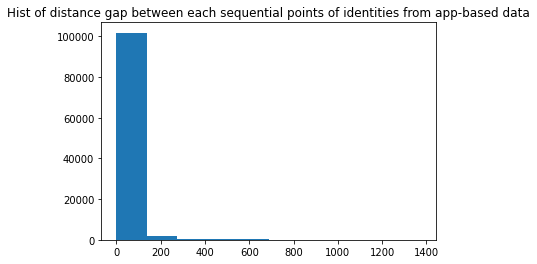

In [210]:
#latlon_file['dist_r'].describe()
#check data
#latlon_file[latlon_file['dist_r']==max(latlon_file['dist_r'])]

#plot distance gap
plt.hist(latlon_file['dist_r'].values)
#plt.boxplot(latlon_file['dist_r'].values)
plt.title('Hist of distance gap between each sequential points of identities from app-based data')

In [177]:
def get_sec(DistinMile, Speed):
    return(DistinMile/Speed*3600)

In [185]:
get_sec(1, 60)

60.0

### Further step
buffer zone in geopandas [(link)](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html)